# **GeolifePrj_02_extrafeatures.ipynb**
>## Usamos los archivos pickle **geolife_xxx.zip** del Notebook **GeolifePrj_00_plt2df.ipynb** y agregamos algunas features (="properties" en geojson) y creamos **geolife_xxx_features.geojson** para una mejor visualización
>## Guardamos como intermediario archivo **geolife_xxx_features.zip**

#### Algunos imports

In [319]:
import geopandas
import numpy as np
import pandas as pd
#from shapely.geometry import Point
from geojson import  Point,Feature, FeatureCollection, dumps
from datetime import timedelta, datetime
import csv, json

import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm

from collections import OrderedDict

from shapely.geometry import LineString
from shapely.geometry import Point

from dateutil.parser import parse as parsedt

#### constantes para tagear los puntos geojson y crear colores

In [168]:
mode_names = ['walk', 'bike', 'bus', 'car', 'subway','train', 
              'airplane', 'boat', 'run', 'motorcycle', 'taxi']
mode_marker = ['pitch', 'bicycle', 'bus', "car", 'rail-underground','rail', 
              'airport', 'ferry', 'pitch', 'scooter', 'car']
mode_color = ['#f16f04', '#1ac16b', '#68aa31', '#8043b1', '#29c6db','#470e53', 
              '#595454', '#2026d5', '#f16f04', '#e52315', '#f6fa00']

mode_ids = {s : i + 1 for i, s in enumerate(mode_names)}
mode_marker_dict = {i + 1:s for i, s in enumerate(mode_marker)}
mode_color_dict = {i + 1:s for i, s in enumerate(mode_color)}

cmaps = {}
cmaps['Uniform'] = [ 'viridis', 'plasma', 'inferno', 'magma', 'cividis','spring','summer','autumn','winter']
cmaps['Diverging'] = [ 'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
            'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']
cmaps['Cyclic'] = ['twilight', 'twilight_shifted', 'hsv']
cmaps['Miscellaneous'] = [ 'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg',
            'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar']

cmap = plt.get_cmap(cmaps['Uniform'][0])
colors.to_hex(cmap(255))

'#fde725'

#### Probamos ver a que corresponde el valor **label**=4 (=modo de transporte)

In [323]:
label = 4
mode_names[label-1], mode_marker_dict[label] , mode_color_dict[label]

('car', 'car', '#8043b1')

## def **read_df_add_features(** *archivo_pickle* **)**:
>### Devuelve: DataFrame **df**
>### - Carga DataFrame **df** ("geolife_xxx.zip") y agrega features : 
>### -  **'vel'** : velocidad aproximada , **velprep** : velocidad preprocesada para eliminar picos , **'velMA'** : velocidad suavizada con Moving Average ( df.col.rolling(...).mean() )
>### - 'velprep' , 'velprep2' , 'velprep3' , 'pruebas' , 'velMA2' y 'velMA3' son postprocesamientos de 'velprep' para tratar de deducir el modo de transporte


In [420]:
#agrega columna de velocidad 'vel' , 'velMA' y velMA2
def read_df_add_features(pickle_file , vel='vel', lat='lat',lon='lon',time='time'):
    df = pd.read_pickle(pickle_file)

    df['idx_traj'] = df.index
    df.idx_traj=df.idx_traj.apply(int)
    df.reset_index(inplace=True,drop=True)
    df[vel]=0
    vel_ix = df.columns.get_loc(vel)
    lat_ix = df.columns.get_loc(lat)
    lon_ix = df.columns.get_loc(lon)
    time_ix = df.columns.get_loc(time)
    factor_r2m=111139*3.6 # gps/t  ->  km/h  // 111139 -> m/s
    lp=100/len(df)
    print("")
    for i in range(1,len(df)):        
        print( f"Calculando velocidades: {(i*lp):.2f}%  ",end="\r")
        d=factor_r2m*((df.iloc[i,lon_ix]-df.iloc[i-1,lon_ix])**2+(df.iloc[i,lat_ix]-df.iloc[i-1,lat_ix])**2)**0.5  #pythagoras entre row(i) y row(i-1=)
        t=(df.iloc[i,time_ix]-df.iloc[i-1,time_ix]).seconds+0.01
        df.iloc[i,vel_ix]=d/t
        """ t=(df.iloc[i,time_ix]-df.iloc[i-1,time_ix]).seconds
        if t==0:
            df.iloc[i,vel_ix]=0
        else:
            df.iloc[i,vel_ix]=np.float(d/t)
            """ 
        
        
    df.iloc[0,vel_ix]=df.vel.iloc[1]
    df.vel=df.vel.apply(lambda x:round(x,2))    
    
    #FEATURES A BASE
    df['velMA']= df[vel].rolling(30, win_type='triang',min_periods=1, center=True).mean()
    clip1 = df.velMA.max()
    media = df.velMA.mean()
    print(f"clip: {clip1}",end=" ")
    df['velprep']=df.vel.apply(lambda x : x if x<clip1 else media )    
    df['velMA']= df['velprep'].rolling(15, win_type='triang',min_periods=1, center=True).mean()
    df['velMA2']= df['velprep'].rolling(45, win_type='hamming',min_periods=1,center=True).mean()          
    df['velMA3']= df['velprep'].rolling(250, win_type='hamming',min_periods=1,center=True).mean() 
    
    df['velprep2']=df.velMA3.apply(lambda x : 5+(15*np.round((x+1)/15)))
    df['pruebas']= df['velprep2'].rolling(450, win_type='hamming',min_periods=1,center=True).mean() 
    df['vel_label']=df.pruebas.apply(lambda x : 2+(30*np.round((x)/30)))   
    
    return df


## def **read_df_add_features_fast(**archivo_pickle**)**:
>### Lo mismo que **read_df_add_features(**archivo**)** pero más rápido y con lo indispensable (no lo uso porque no es más rápido al final)

In [421]:
from math import sqrt
#agrega columna de velocidad 'vel' , 'velMA' y velMA2
def read_df_add_features_fast(pickle_file , vel='vel', lat='lat',lon='lon',time='time'):
    df = pd.read_pickle(pickle_file)
    
    df['idx_traj'] = df.index
    df.idx_traj=df.idx_traj.apply(int)
    df.reset_index(inplace=True,drop=True)
    df[vel]=0
    vel_ix = df.columns.get_loc(vel)
    lat_ix = df.columns.get_loc(lat)
    lon_ix = df.columns.get_loc(lon)
    time_ix = df.columns.get_loc(time)
    factor_r2m=111139*3.6 # gps/t  ->  km/h  // 111139 -> m/s
    lp=100/len(df)    
    print("")
    for i in range(1,len(df)):
        print( f"Calculando velocidades: {(i*lp):.2f}%  ",end="\r")
        d=factor_r2m*sqrt(((df.iloc[i,lon_ix]-df.iloc[i-1,lon_ix])**2+(df.iloc[i,lat_ix]-df.iloc[i-1,lat_ix])**2)) #pythagoras entre row(i) y row(i-1=)
        t=(df.iloc[i,time_ix]-df.iloc[i-1,time_ix]).seconds+0.01
        #if t==0:
        #    df.iloc[i,vel_ix]=0
        #else:
        df.iloc[i,vel_ix]=d/t
            
    df.iloc[0,vel_ix]=df.vel.iloc[1]
    
    #FEATURES A BASE
    df['velMA']= df[vel].rolling(30, win_type='triang',min_periods=1, center=True).mean()
    clip1 = df.velMA.max()
    media = df.velMA.mean()
    print(f"clip: {clip1}",end=" ")
    df['velprep']=df.vel.apply(lambda x : x if x<clip1 else media )            
    df['velMA3']= df['velprep'].rolling(250, win_type='hamming',min_periods=1,center=True).mean()     
    df['velprep']=df.velMA3.apply(lambda x : 5+(15*np.round((x+1)/15)))
    
    return df


## def **plot_evolucion_vel(**df , start_dt, end_dt,...):
>### Plotea la columna 'vel' vs 'time' y otras estadísticas del **DataFrame** df ( DataFrame creado con **df=read_df_add_features(** *pickle_file* ,...**)** )

In [372]:
def plot_evolucion_vel( df,start_dt , end_dt , vel='vel', tit="Evolucion de velocidad"):
    #muestra velocidad a través del tiempo
    if not isinstance(start_dt, datetime):
        start_dt = parsedt(start_dt)
    if not isinstance(end_dt, datetime):
        end_dt = parsedt(end_dt)
    
    f=plt.figure(figsize=(20,10))
    plt.xlabel(f'TIEMPO: del  {start_dt}  al  {end_dt}', fontsize=16)
    plt.ylabel('VELOCIDAD [km/h]', fontsize=16)
    df = df.loc[(df.time > start_dt) & (df.time < end_dt)]
    if(len(df)==0):
        f.suptitle("No hay datos en este rango de fechas!", fontsize=26)
    else:
        f.suptitle(tit, fontsize=26)
        

    #rangotiks=df.velMA.nlargest(20).index.values.tolist()
    #rangotiks.extend(df.velMA.nsmallest(20).index.values.tolist())
    rangotiks=range(df.index[0],df.index[len(df)-1],round(len(df)/20+1))
    print(rangotiks)
    print(df.index[0],df.index[len(df)-1])
    rangolabels = list(df.loc[df.index.isin(rangotiks), 'time'])
    plt.xticks(ticks=rangotiks, labels=rangolabels,  rotation=90)
    
    plt.plot(df[vel] , 'b')
    plt.plot(df.velMA, 'ro') 
    plt.plot(df.velMA2, 'g')     
    plt.plot(df.velMA3, 'y')     
    plt.plot(df.pruebas, 'k')      
    plt.plot(df.vel_label, 'c') 
    
    #plt.axvline(x=100)
    #plt.axvline(x=0.33088437)
    #plt.axvline(x=2.20589566)


## Cargamos el *archivo*=**geolife_xxx.zip** y le agregamos features con df=**read_df_add_features(** *archivo*,...**)** 
>### y finalmente hacemos 
### df**.to_pickle("geolife_xxx_features.zip")**

In [ ]:
%%time
#solo se cambia este numero

x_x=[0,1,52,111,113]
xxx=x_x[0]
for xxx in [a  for a in range(68,182) if a not in x_x]:
    archivo=f"geolife_{xxx:03d}.zip"
    archivo_salida=archivo[:-4]+"_features.zip"
    print(f"Cargando y procesando {archivo} / ",end="")
    df=read_df_add_features(archivo)
    #df=read_df_add_features(archivo)
    print(f"Guardando a {archivo_salida} ")
    df.to_pickle(archivo_salida)
df

Cargando y procesando geolife_010.zip / 
clip: 6322.197888888888 100.00%  Guardando a geolife_010_features.zip 
Cargando y procesando geolife_011.zip / 
clip: 7912.1804 idades: 100.00%  Guardando a geolife_011_features.zip 
Cargando y procesando geolife_012.zip / 
clip: 1744.1617777777776 00.00%  Guardando a geolife_012_features.zip 
Cargando y procesando geolife_013.zip / 
clip: 15999.698177777778 00.00%  Guardando a geolife_013_features.zip 
Cargando y procesando geolife_014.zip / 
clip: 749.8374666666666 100.00%  Guardando a geolife_014_features.zip 
Cargando y procesando geolife_015.zip / 
clip: 4101.692822222222 100.00%  Guardando a geolife_015_features.zip 
Cargando y procesando geolife_016.zip / 
clip: 5069.755777777779 100.00%  Guardando a geolife_016_features.zip 
Cargando y procesando geolife_017.zip / 
clip: 1860.5724444444445 00.00%  Guardando a geolife_017_features.zip 
Cargando y procesando geolife_018.zip / 
clip: 445.8053555555555 100.00%  Guardando a geolife_018_featur

In [428]:
start_ix=df.loc[df.idx_traj==0].index.tolist()
end_ix = [ i-1 for i in start_ix[1:]]
end_ix.append(len(df)-1)
print(start_ix,"\n",end_ix)

[0, 1228, 2224, 3720, 4306, 4946, 5080, 6151, 6680, 7151, 8407, 9307, 13901, 15577, 15964, 18360, 21062, 21748, 22730, 23684, 24195, 26018, 28001, 31444, 33338, 36078, 37494, 39264, 40791, 41529, 45853, 47964, 52002, 54326, 55510, 56388, 57332, 58875, 62055, 64247, 66234, 68987, 70166, 72683, 73143, 76498, 76877, 78724, 81425] 
 [1227, 2223, 3719, 4305, 4945, 5079, 6150, 6679, 7150, 8406, 9306, 13900, 15576, 15963, 18359, 21061, 21747, 22729, 23683, 24194, 26017, 28000, 31443, 33337, 36077, 37493, 39263, 40790, 41528, 45852, 47963, 52001, 54325, 55509, 56387, 57331, 58874, 62054, 64246, 66233, 68986, 70165, 72682, 73142, 76497, 76876, 78723, 81424, 84615]


#### Mostramos una pequeña estadística antes de comenzar (se ve que la mayor parte del tiempo se mueve lento o no se mueve)

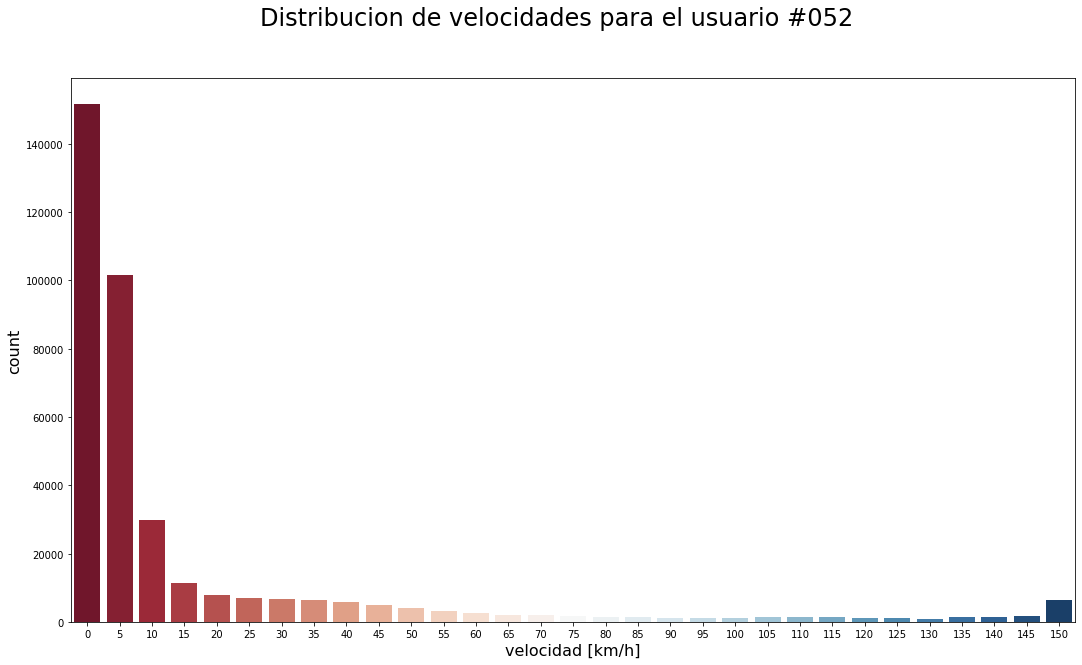

In [398]:
l=[e if e<150 else 150 for e in list(df.vel.apply(lambda x:5*round(x/5))) ]

f=plt.figure(figsize=(18,10))
f.suptitle(f'Distribucion de velocidades para el usuario #{df.user[0]:03d}', fontsize=24)
plt.xlabel('velocidad [km/h]', fontsize=16)
plt.ylabel('features', fontsize=16)
#ax.set_title("Distribucion de velocidades [km/h]", fontsize=14)
sns.countplot(l , palette="RdBu")

### Calcula inicio y fin de trayectorias (cada trayectoria equivale a la data de un solo archivo .plt original)

In [369]:
start_ix=df.loc[df.idx_traj==0].index.tolist()
end_ix = [ i-1 for i in start_ix[1:]]
end_ix.append(len(df)-1)
print("Indices de inicio y fin de cada trayectoria")
print("Inicio: ",start_ix,"\nFin:",end_ix)
for i in range(len(start_ix)):
    s_str=df.loc[start_ix[i],'time']
    e_str=df.loc[end_ix[i],'time']
    print("Trayectoria:",i,":",s_str," <--> ",e_str)

Indices de inicio y fin de cada trayectoria
Inicio:  [0, 30, 107, 1436, 1460, 1498, 1511, 1530, 1607, 1613, 1757, 1866, 1891, 1938, 1959, 2587, 2608, 2622, 3431, 3462, 4478, 4646, 4939, 4954, 4966, 4974, 4980, 4989, 5047, 5393, 5447, 5511, 5569, 6494, 6861, 7303, 7715, 8636, 9379, 10290, 11327, 12119, 12933, 14527] 
Fin: [29, 106, 1435, 1459, 1497, 1510, 1529, 1606, 1612, 1756, 1865, 1890, 1937, 1958, 2586, 2607, 2621, 3430, 3461, 4477, 4645, 4938, 4953, 4965, 4973, 4979, 4988, 5046, 5392, 5446, 5510, 5568, 6493, 6860, 7302, 7714, 8635, 9378, 10289, 11326, 12118, 12932, 14526, 15325]
Trayectoria: 0 : 2007-04-13 15:23:30  <-->  2007-04-13 15:42:54
Trayectoria: 1 : 2007-04-14 03:36:16  <-->  2007-04-14 03:57:02
Trayectoria: 2 : 2007-04-15 00:49:23  <-->  2007-04-15 09:06:57
Trayectoria: 3 : 2007-04-15 10:44:58  <-->  2007-04-15 11:03:10
Trayectoria: 4 : 2007-04-16 14:44:10  <-->  2007-04-16 15:13:37
Trayectoria: 5 : 2007-04-17 02:07:24  <-->  2007-04-17 02:14:52
Trayectoria: 6 : 2007-04-

# Plot Evolucion de velocidades por trayectorias

2009-09-23 09:20:00  <-->  2009-09-23 09:21:10
range(1, 13, 2)
1 13
2009-09-23 15:43:35  <-->  2009-09-23 22:04:18
range(16, 3089, 155)
16 3089
2009-09-24 18:30:29  <-->  2009-09-24 23:19:54
range(3092, 5249, 109)
3092 5249
2009-09-26 19:09:29  <-->  2009-09-26 22:52:17
range(5252, 7272, 102)
5252 7272
2009-09-27 08:33:34  <-->  2009-09-27 16:12:13
range(7275, 8826, 79)
7275 8826


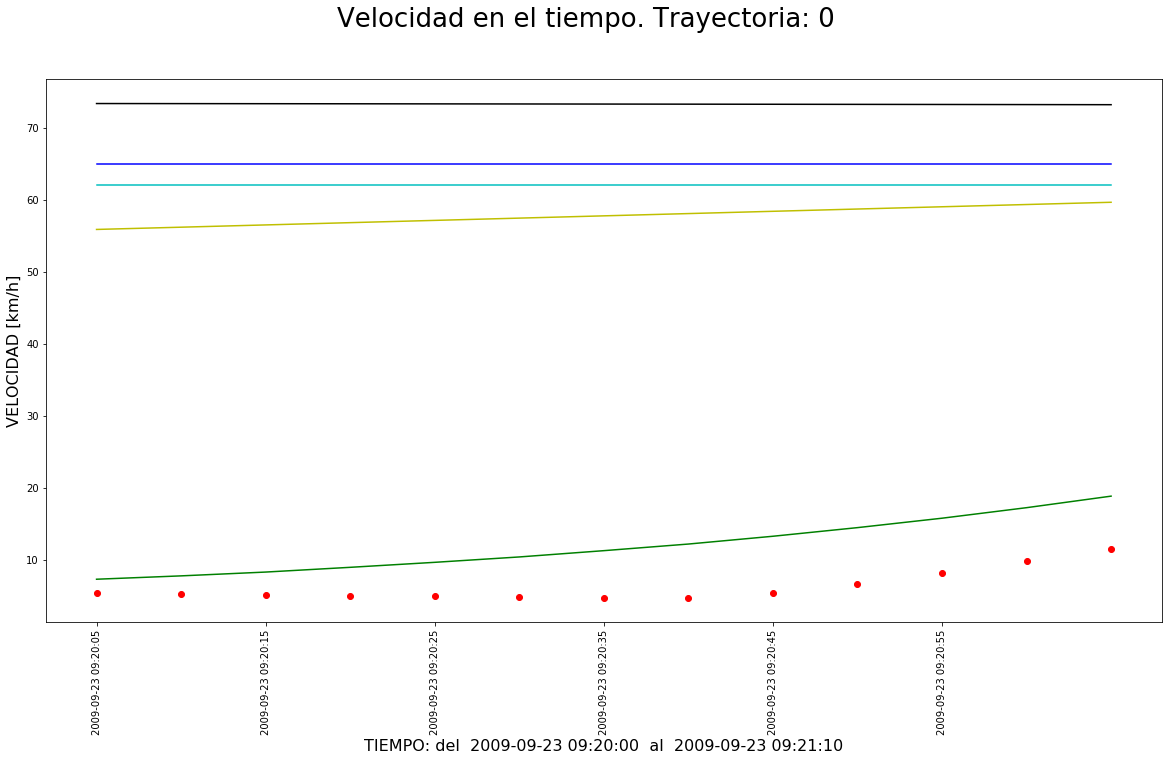

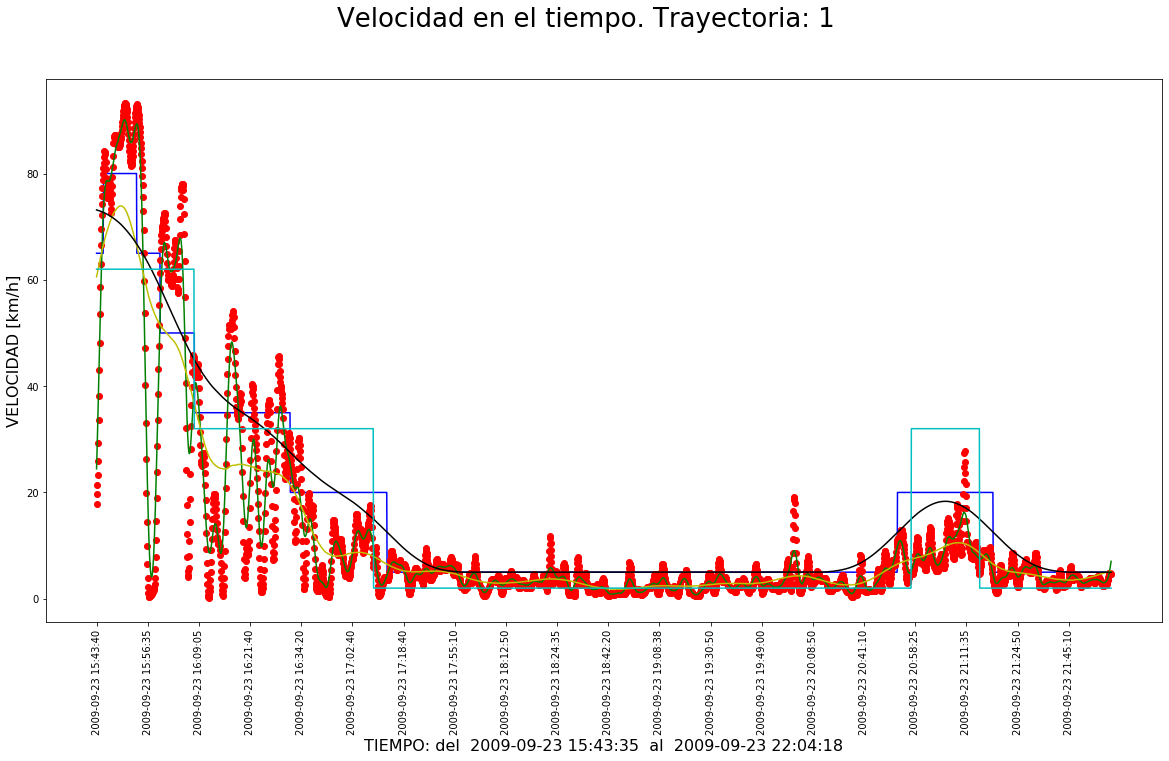

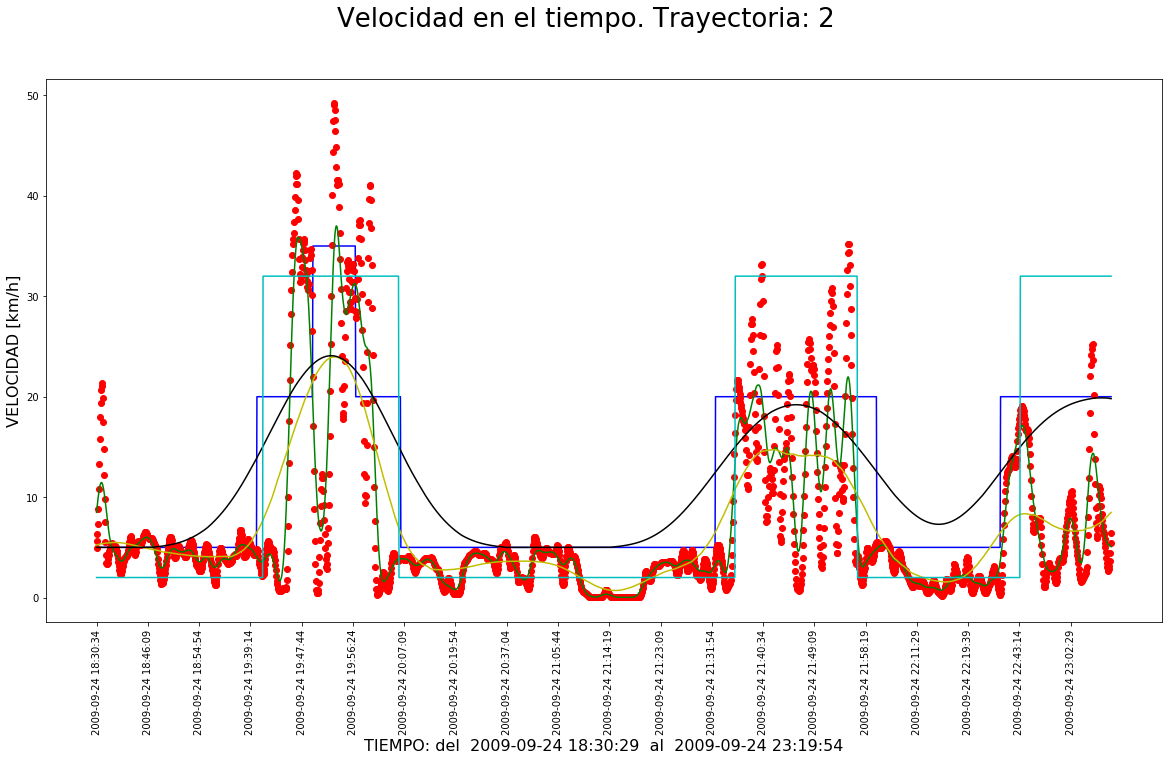

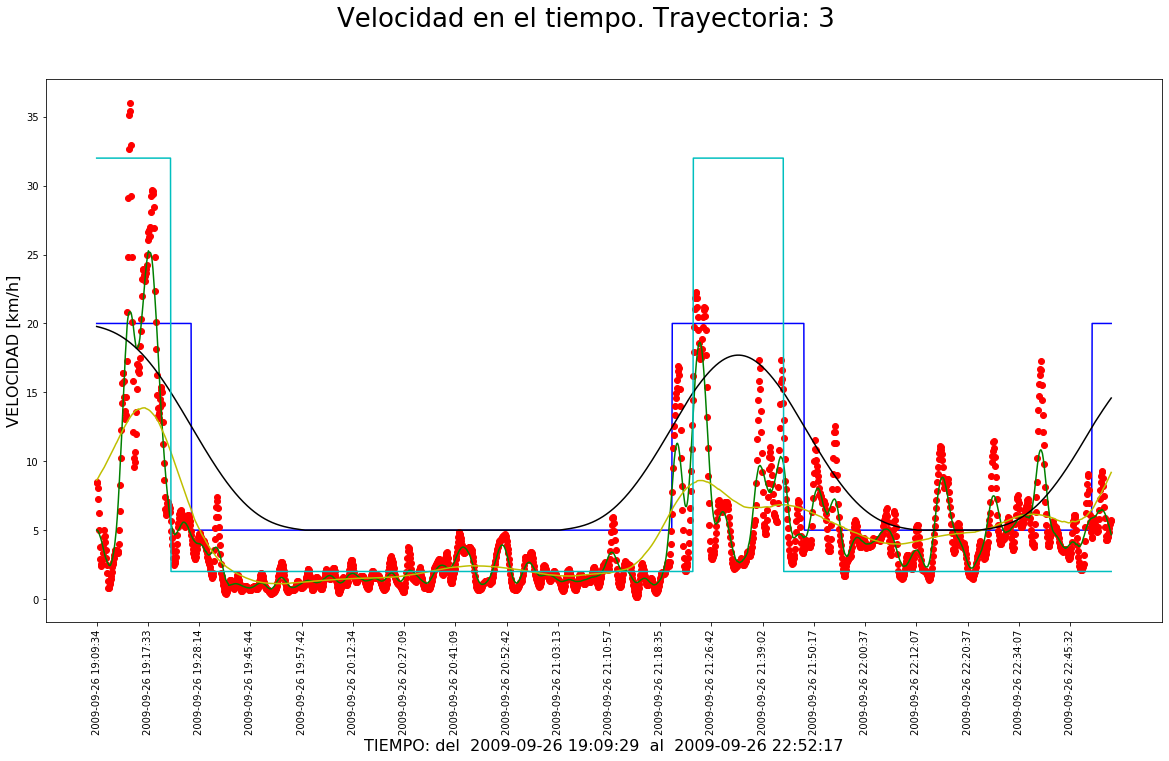

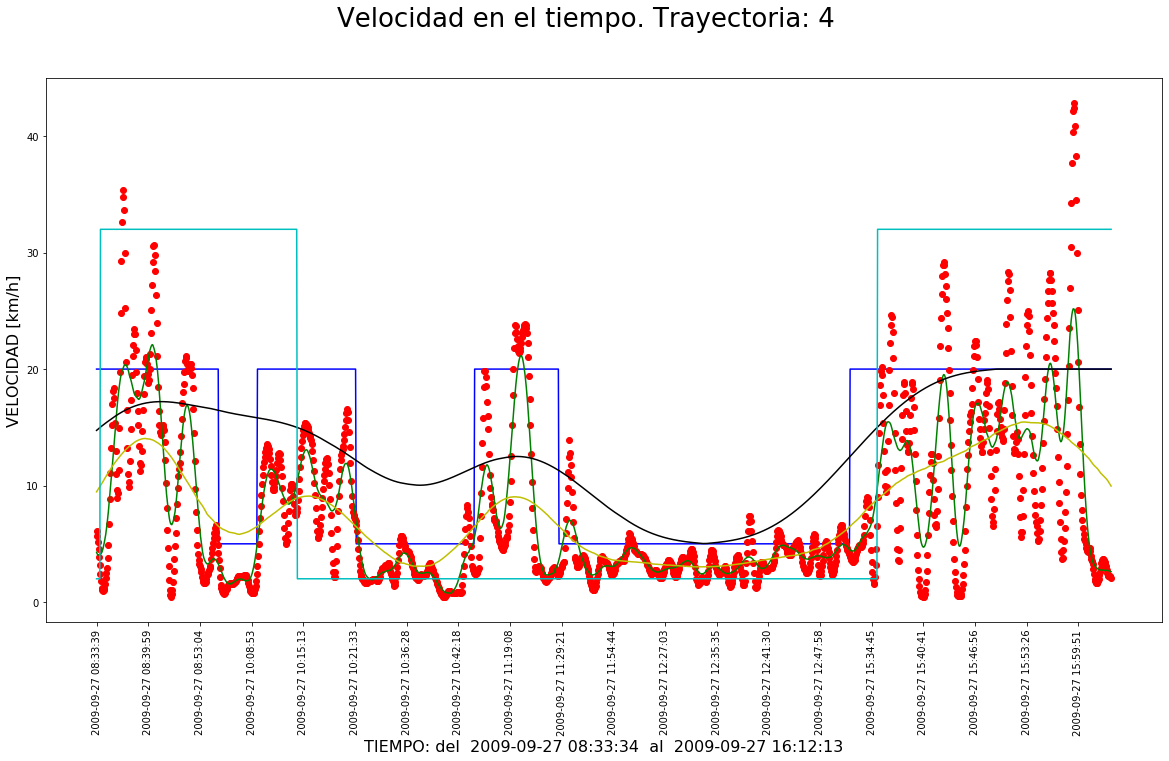

In [315]:

for trayectoria,rangodt in [ (idx, x) for idx,x in enumerate(zip(start_ix,end_ix)) ] : #if idx<24
    s_str=df.loc[rangodt[0],'time']
    e_str=df.loc[rangodt[1],'time']
    print(s_str," <--> ",e_str)
    plot_evolucion_vel(df,s_str,e_str, vel='velprep2' , tit=f"Velocidad en el tiempo. Trayectoria: {trayectoria}")


In [253]:
print(df.loc[0,'time']," ",df.loc[len(df)-1,'time'])

2009-09-23 09:20:00   2009-09-27 16:12:13


2008-10-30 00:09:23  <-->  2008-10-30 11:24:05
range(7152, 8405, 64)
7152 8405
2008-10-31 10:22:52  <-->  2008-10-31 11:16:05
range(8408, 9305, 46)
8408 9305
2008-11-01 02:44:05  <-->  2008-11-01 10:45:05
range(9308, 13899, 231)
9308 13899
2008-11-02 10:20:28  <-->  2008-11-02 13:22:38
range(13902, 15575, 85)
13902 15575
2008-11-03 00:19:23  <-->  2008-11-03 00:35:48
range(15578, 15962, 20)
15578 15962
2008-11-03 10:34:29  <-->  2008-11-03 14:46:09
range(15965, 18358, 121)
15965 18358
2008-11-04 00:12:05  <-->  2008-11-04 11:46:48
range(18361, 21060, 136)
18361 21060
2008-11-04 14:15:47  <-->  2008-11-04 14:39:53
range(21063, 21746, 35)
21063 21746
2008-11-05 00:09:23  <-->  2008-11-05 04:29:13
range(21749, 22728, 50)
21749 22728


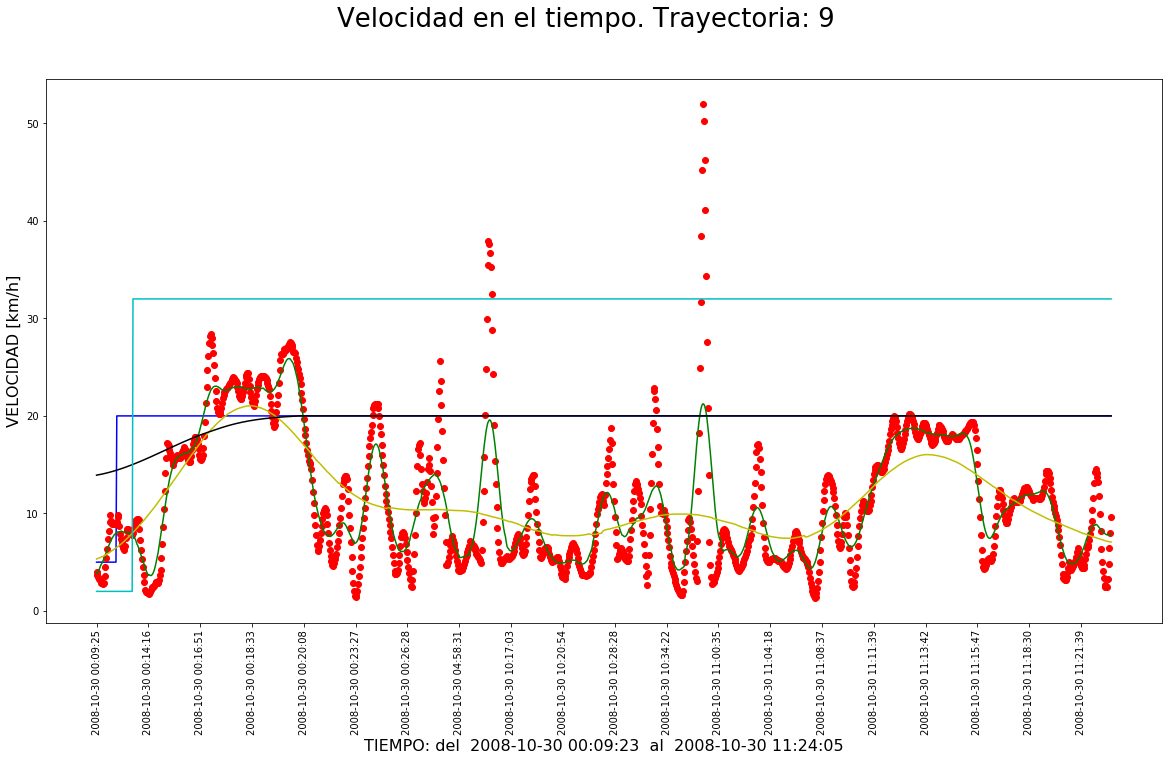

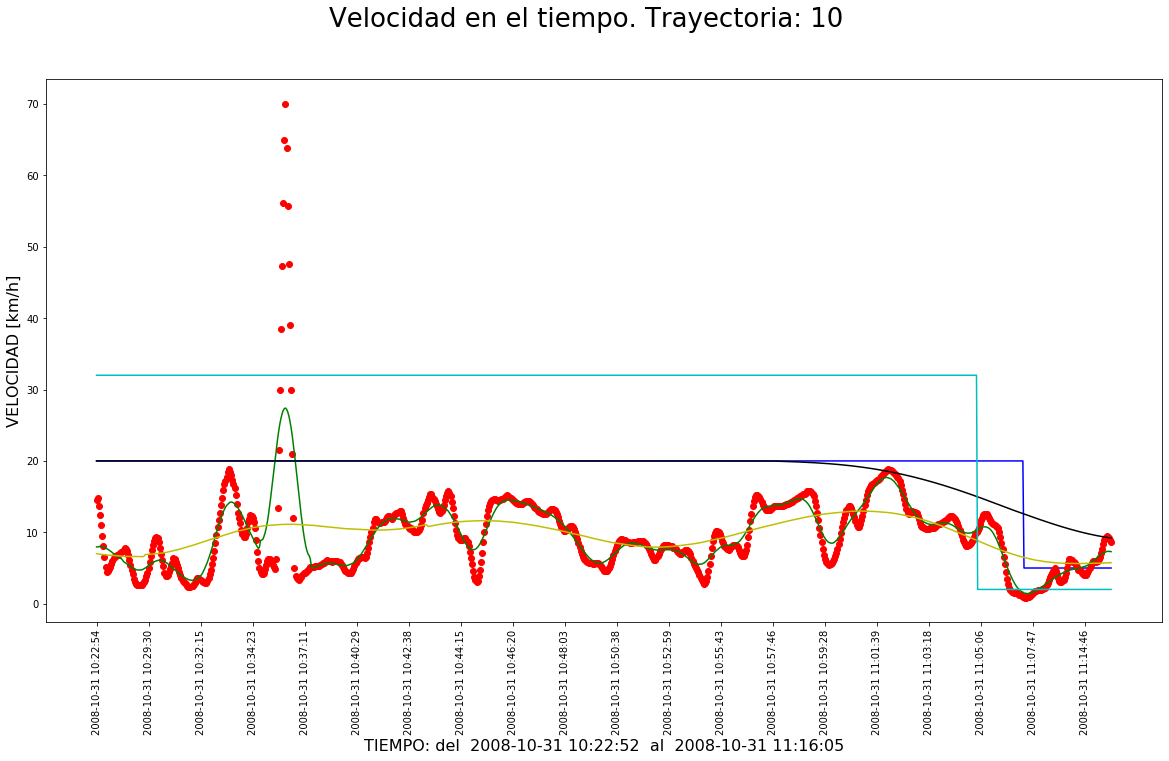

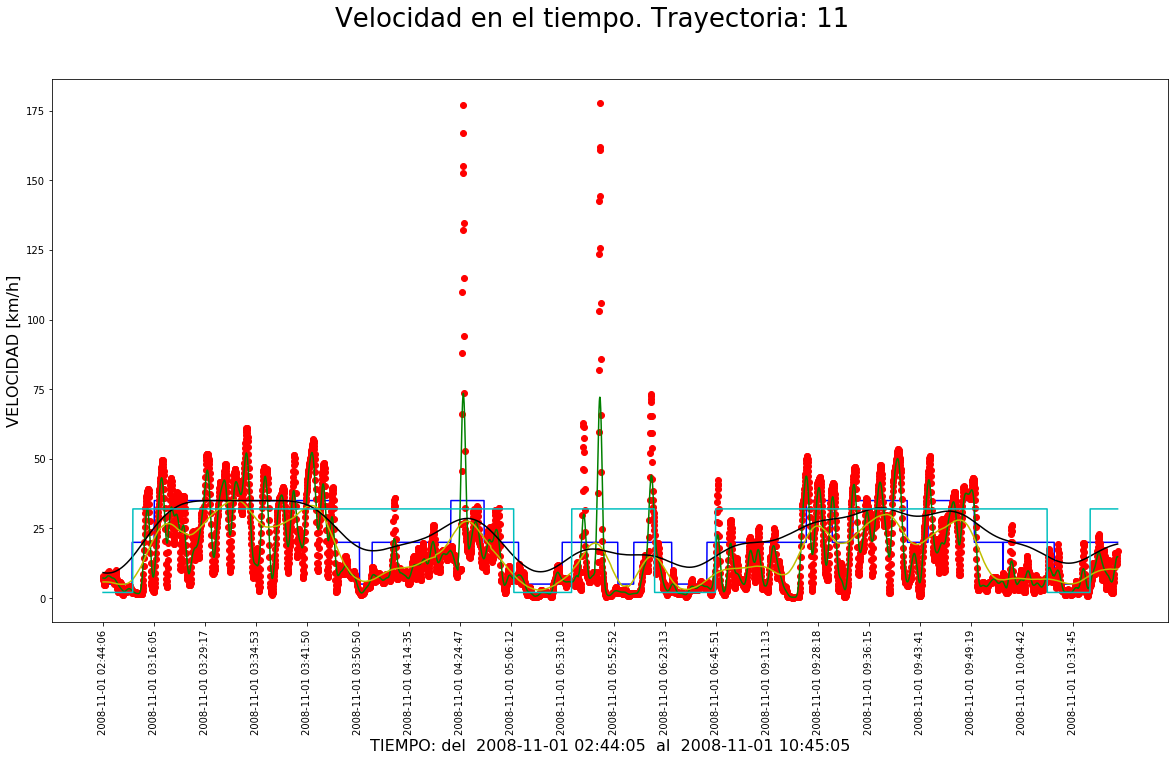

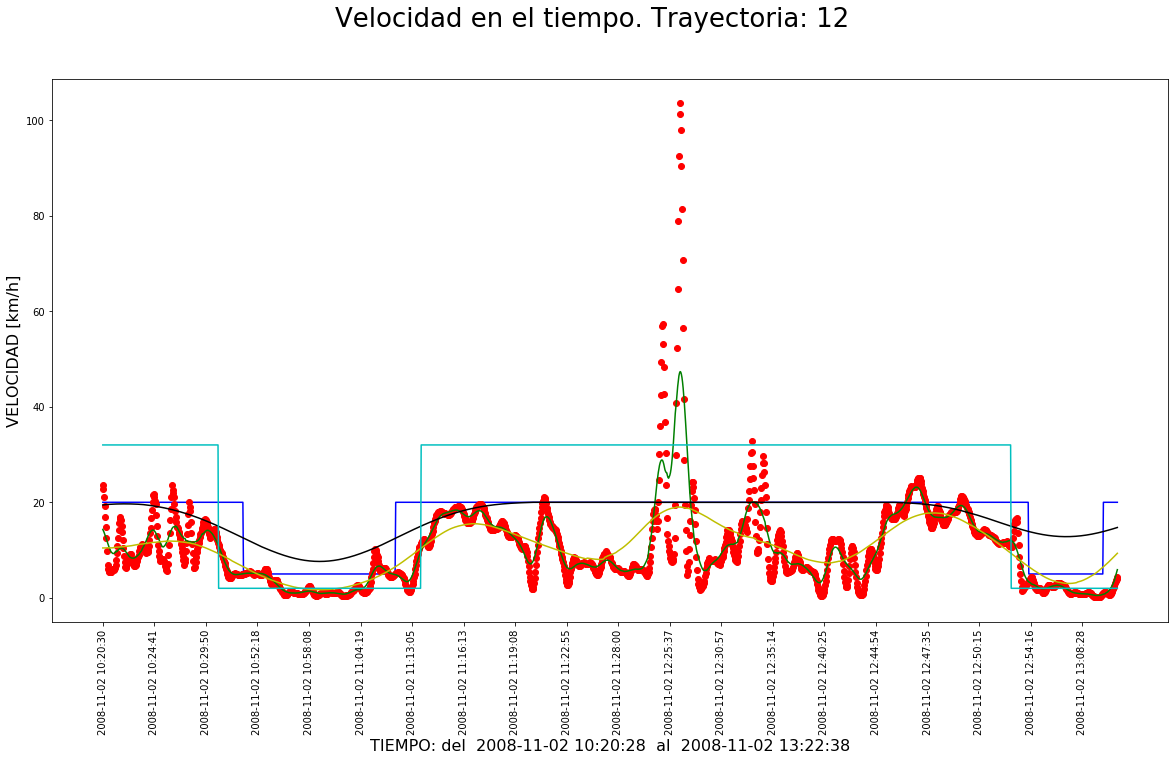

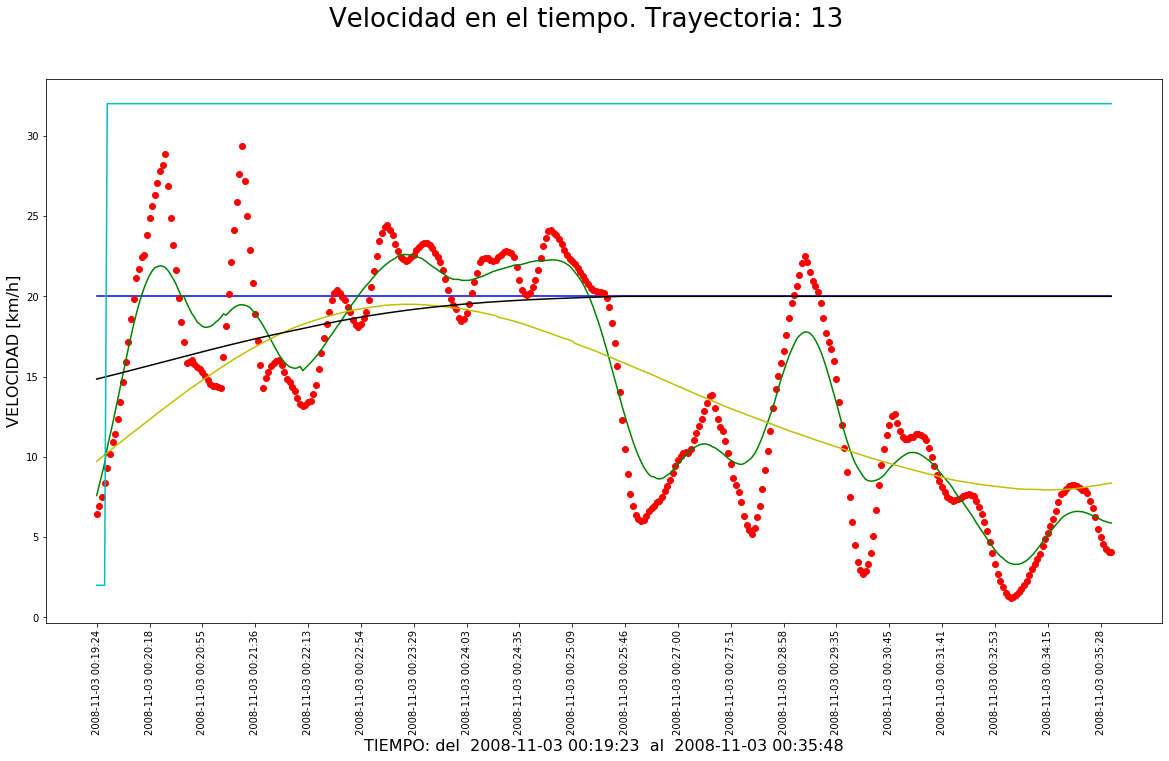

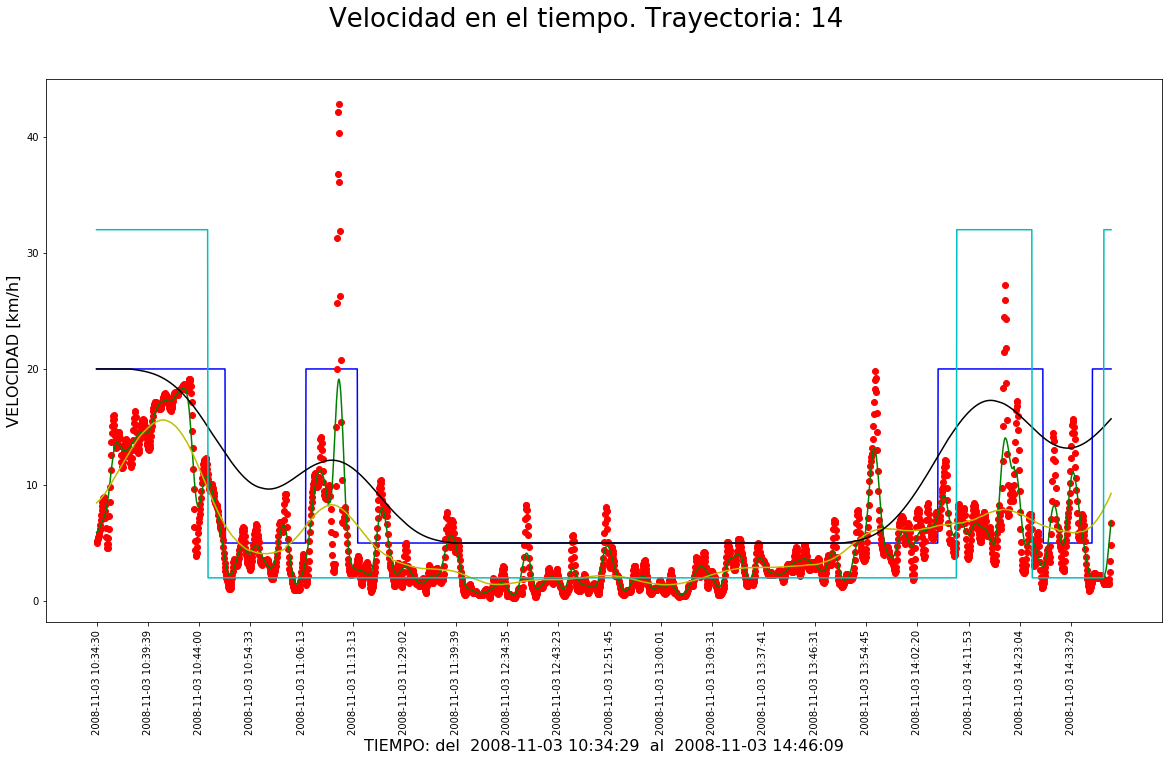

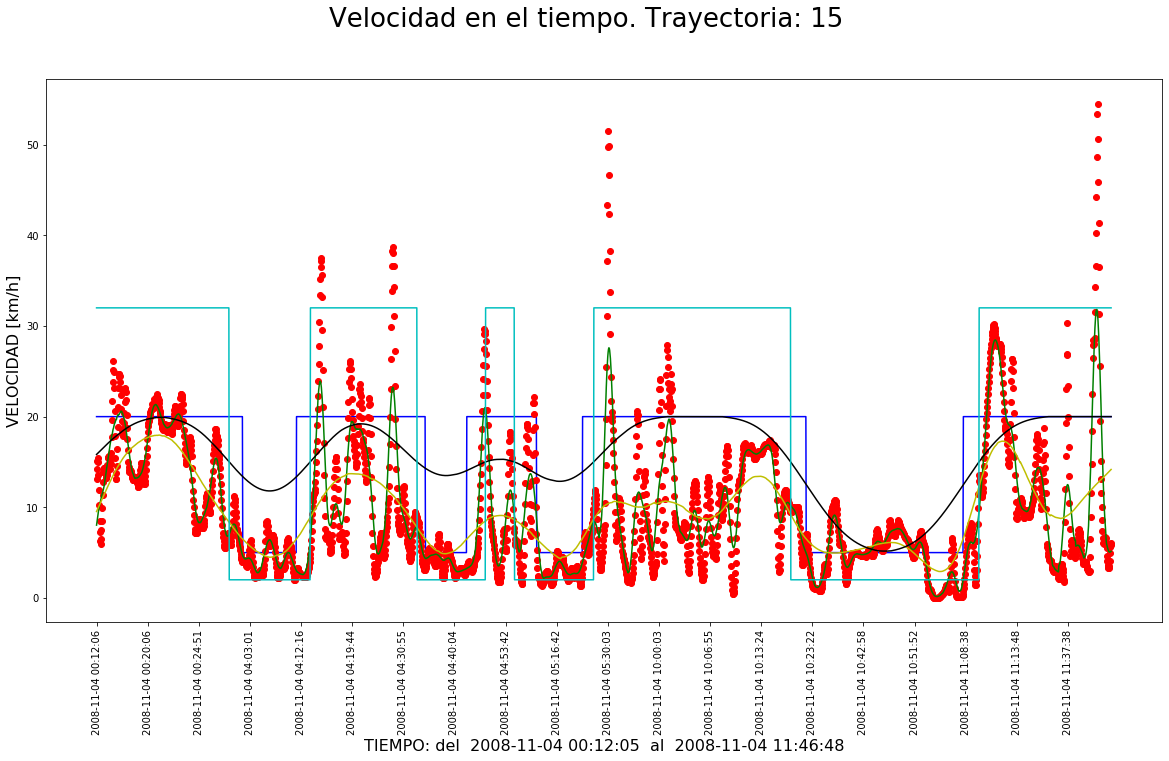

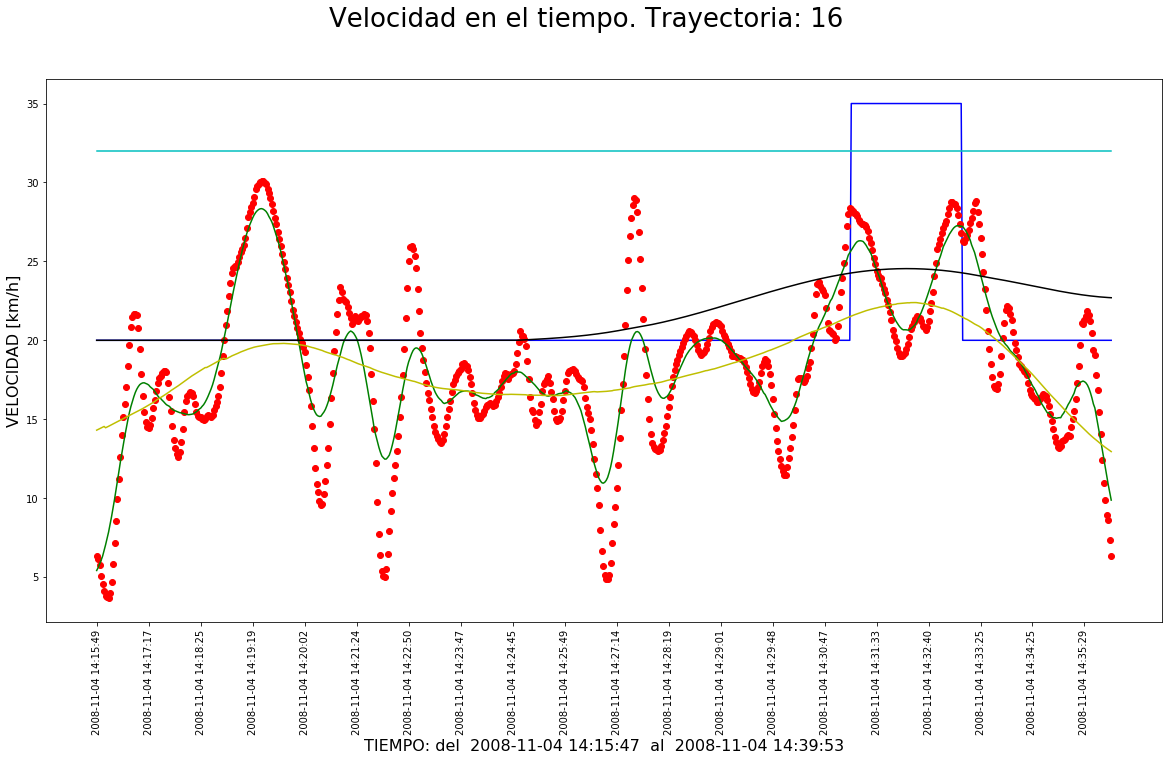

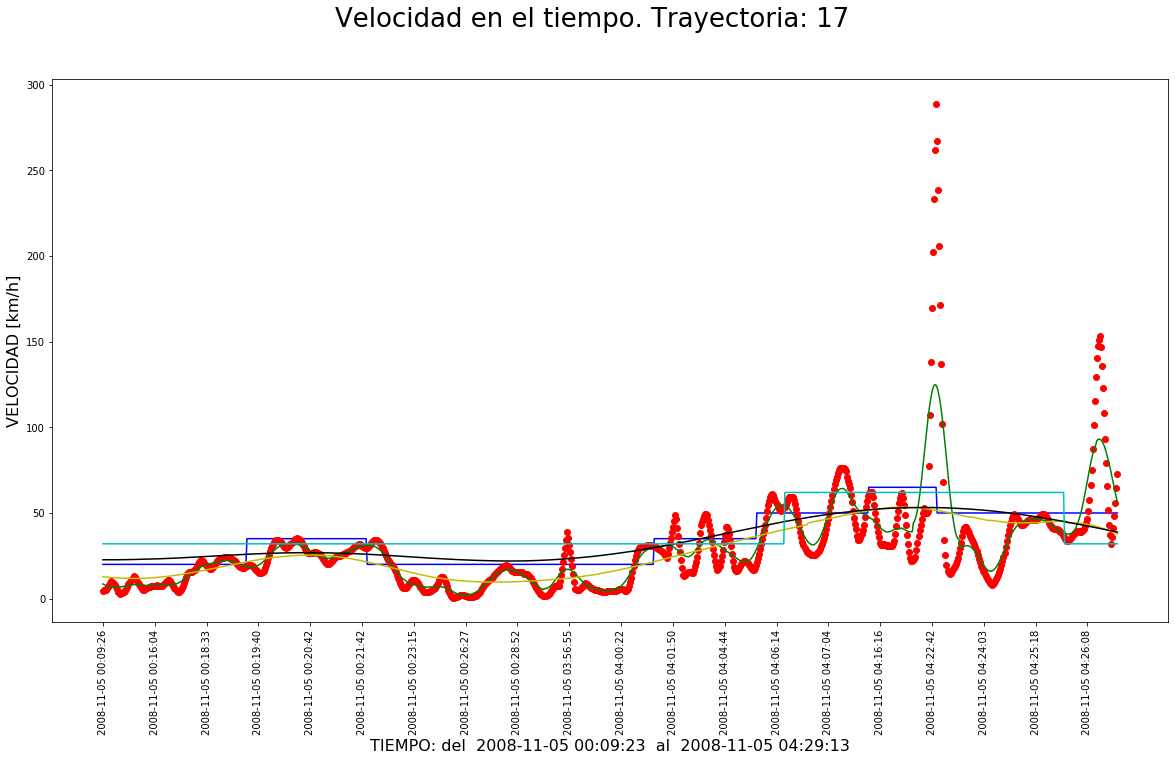

In [431]:

for trayectoria,rangodt in [ (idx, x) for idx,x in enumerate(zip(start_ix,end_ix)) if (idx>8 and idx<18)] : #if idx<24
    s_str=df.loc[rangodt[0],'time']
    e_str=df.loc[rangodt[1],'time']
    print(s_str," <--> ",e_str)
    plot_evolucion_vel(df,s_str,e_str, vel='velprep2' , tit=f"Velocidad en el tiempo. Trayectoria: {trayectoria}")


In [383]:
df = pd.read_pickle("geolife_111_features.zip")

2008/06/27 00:06:06  <-->  2008/06/27 02:06:26
range(186654, 186721, 4)
186654 186721


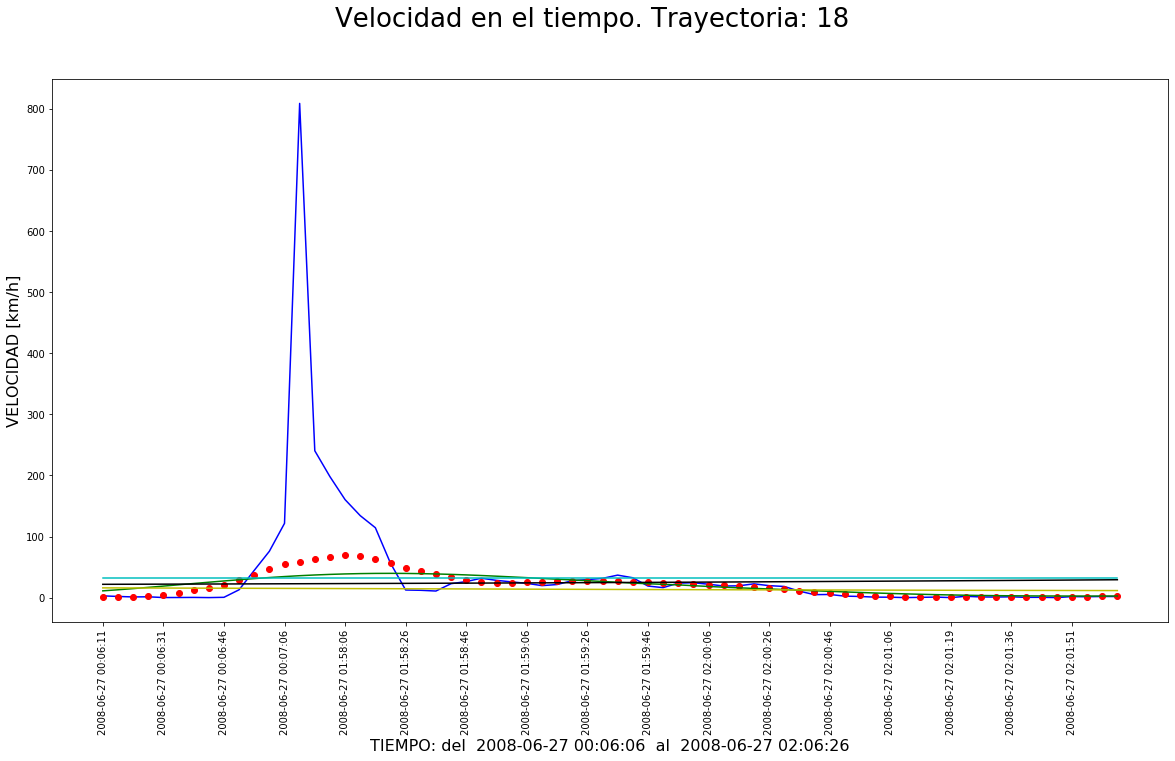

In [411]:
#s_str=df.loc[start_ix[1],'time']
#e_str=df.loc[end_ix[1],'time']
#2007/09/05 00:20:00	2007/09/05 05:17:00	airplane
#2008/06/26 23:40:00	2008/06/27 01:58:26	airplane
s_str="2008/06/27 00:06:06"
e_str="2008/06/27 02:06:26"
print(s_str," <--> ",e_str)
#df['velprep2']=df.velMA3.apply(lambda x : 5+(20*np.round((x-5)/20)))
#df['velprep2']=df.velMA3.apply(lambda x : 5+(5*np.round((x-15)/15) if ( x < 20 ) else 5+(40*np.round((x-5)/40) )) )
plot_evolucion_vel(df,s_str,e_str, vel='vel' , tit=f"Velocidad en el tiempo. Trayectoria: {trayectoria}")